### Gold Nanospheres Simulation

Instructions for use: 
1. Enter the Nanosphere diameter required
2. Specify the medium.
3. Analyse the output UV spectrum consisting of Absorption, Extinction and Scattering.
4. See the expected colour of the solution as well.

<img src="Screenshot (2).png">

Scattering is a process where the total quantity of energy is conserved during the scattering process, the radiation's path may change.

Absorption removes energy from the electromagnetic radiation field, and converts it to another form. 

Extinction (or attenuation) is the sum of scattering and absorption, so it represents total effect of medium on radiation passing the medium.

In [9]:
#necessary imports
import numpy as np
import matplotlib.pyplot as plt
import miepython # Miepython is a python package for calculating Mie scattering properties of a sphere based on the Mie theory 
from colour import Color # Colour is a python package for visualizing colours based on the RGB model

In [10]:
reference_idx = np.loadtxt("Refractive_Index_Au.txt") #contains the dataset containing the optical properties of gold (real and imaginary part of the refractive index)
indexes = reference_idx[:,0] # indexes of the dataset
real = reference_idx[:,1] # real part of the refractive index
imag = reference_idx[:,2] # imaginary part of the refractive index

print("Enter the diameter of the nanoparticle in nm:")
diameter = int(input())

print("Select the surrounding medium (air, water, acetone, ethanol, toluene, hexane or CTAB):") 
env=input()

Enter the diameter of the nanoparticle in nm:
Select the surrounding medium (air, water, acetone, ethanol, toluene, hexane or CTAB):


In [11]:
# choosing the environment of the nanoparticle
# assigning the refractive index of the environment
if env=='air':
    env=1.000
elif env=='water':
    env=1.333
elif env=='acetone':
    env=1.359
elif env=='ethanol':
    env=1.36
elif env=='toluene':
    env=1.496
elif env=='hexane':
    env=1.375
elif env=='CTAB':
    env=1.46
else:
    print("Invalid input") # if the input is not one of the above, the program will terminate

The UV Spectrum of a Gold Nanoparticle is plotted using miepython mie function which takes into input the refractive indexes and the corresponding wavelength in the environment. Note that we are plotting all the three phenomenon i.e. Absorption, Scattering and Extinction.

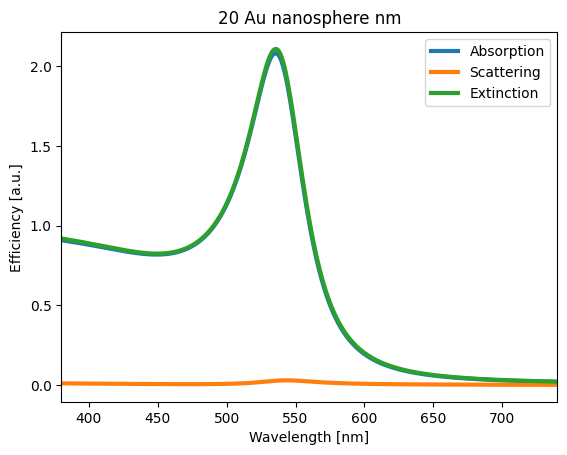

In [12]:
# Sanity check: If the input parameters are correct, proceed further. Otherwise, exit.
if isinstance(env, float)==True:
    # Calculate the scattering (Scatter), absorption (Absorb) and extinction (Extinct) efficiencies
    num = len(indexes)
    m = (real-1.0j*imag)/env # relative refractive index of nanoparticle wrt surrounding medium
    var = ((np.pi)*diameter)/indexes*env # Wavelength of the plane wave in the environment
    
    Absorb = np.zeros(num) # Initial absorption efficiency
    Scatter = np.zeros(num) # Initial scattering efficiency
    Extinct = np.zeros(num) # Initial extinction efficiency

    for i in range(num) :
        # ext: the total extinction efficiency
        # scat: the scattering efficiency
        # back: the backscatter efficiency
        # g: the average cosine of the scattering phase function
        ext, scat, back, g = miepython.mie(m[i],var[i]) 
        # print(ext,scat,back)
        qabs = ext - scat  #Extinction = Absorbtion + Scattering
        Absorb[i]=qabs
        Scatter[i]=scat
        Extinct[i]=ext

    # Plotting the absorption, scattering and extinction efficiencies v/s Wavelength
    fig, ax = plt.subplots()
    ax.plot(indexes, Absorb, linewidth = '3')
    ax.plot(indexes, Scatter, linewidth = '3')
    ax.plot(indexes, Extinct, linewidth = '3')
    ax.set(xlabel='Wavelength [nm]', xlim = (380, 740), ylabel='Efficiency [a.u.]', title='{}'.format(diameter)+' Au nanosphere nm')
    ax.legend(['Absorption', 'Scattering', 'Extinction'])
    plt.show()
else:
    exit

Now in order to visualize the colours of the three phenomenon, we have used CIE 1931 2-deg colour matching function to map the efficiencies to the colour. CIR Standard D65 Illuminant is a commonly used standard illuminant for comparing colours.

In [13]:
# Spectrum to color conversion
# Load CIE 1931 2-deg color matching functions http://cvrl.ioo.ucl.ac.uk/ CIE 
if isinstance(env, float)==True: #Sanity check 
    CMF = np.loadtxt("Colour_Mapping.txt") # Colour Matching Function based on RGB system of colour identification
    x = CMF[:,1]
    y = CMF[:,2]
    z = CMF[:,3]
    D65 = CMF[:,4] # Commonly used standard illuminant D65
    # Conversion matrix from XYZ to standard RGB(sRGB)
    convert_xyz_rgb=np.array([[3.2404542, -1.5371385, -0.4985314],
                              [-0.9692660,  1.8760108,  0.0415560], 
                              [0.0556434, -0.2040259,  1.0572252]])

    spectra = np.column_stack((Absorb, Scatter, Extinct))
    RGB = np.zeros((3,3)) # Initial RGB values
    for i in range(3):
        spectrum = spectra[:,i] # Convert the spectrum to CIE chromaticity values (X,Y,Z) by integrating the spectrum over the color matching functions
        x_r_sum=np.sum(x*D65*spectrum)
        y_r_sum=np.sum(y*D65*spectrum)
        z_r_sum=np.sum(z*D65*spectrum)

        x_sum=np.sum(x*D65)
        y_sum=np.sum(y*D65)
        z_sum=np.sum(z*D65)

        X = x_r_sum/y_sum # Remove the intensity dependance of the calculated color values
        Y = y_r_sum/y_sum
        Z = z_r_sum/y_sum

        xx = X/(X+Y+Z) # Calculate normalized chromaticities 
        yy = Y/(X+Y+Z)
        zz = Z/(X+Y+Z)

        # Convert to standard linear RGB
        RGB[i,:]=np.dot(convert_xyz_rgb,[xx,yy,zz])
    
    # Converting the linear RGB values to nonlinear RGB values by gamma correction, reference: https://en.wikipedia.org/wiki/SRGB#The_forward_transformation_(CIE_XYZ_to_sRGB)
    for i in range(3):
        for j in range(3):
            if RGB[i,j] <= 0.0031308:
                RGB[i,j] = 12.92*RGB[i,j]
            else:
                RGB[i,j] = 1.055*RGB[i,j]**(1/2.4)-0.055
        # Remove negative values and values greater than 1
            if RGB[i,j] < 0:
                RGB[i,j] = 0
            if RGB[i,j] > 1:
                RGB[i,j] = 1      
    # Display the RGB values in the 0...255 range.
    # For the extinction spectrum, the opposite color is displayed to represent the perceived color
    print("Absorbed color: ",Color(rgb = np.around(RGB[0,:])))
    print("Scattered color: ",Color(rgb = np.around(RGB[1,:])))
    print("Transmitted color: ",Color(rgb = np.around(RGB[2,:])))
else:
    exit # Exit the program if the input parameters are not correct

Absorbed color:  cyan
Scattered color:  lime
Transmitted color:  cyan


References:
1. https://github.com/aftenieva/plasmonic-colors
2. https://en.wikipedia.org/wiki/SRGB#The_forward_transformation_(CIE_XYZ_to_sRGB)
3. https://computergraphics.stackexchange.com/questions/5947/rgb-nonlinear-what-does-it-mean
4. https://www.image-engineering.de/library/technotes/958-how-to-convert-between-srgb-and-ciexyz
5. http://cvrl.ioo.ucl.ac.uk/
6. https://miepython.readthedocs.io/en/latest/03_angular_scattering.html
7. https://github.com/scottprahl/miepython
8. https://www.gfdl.noaa.gov/wp-content/uploads/files/user_files/pag/lecture2008/lecture3.pdf